In [96]:
import os
import time
import random
import functools
import multiprocessing
from typing import Tuple, Callable

import pandas as pd
import numpy as np
import cv2
from numba import njit
from tqdm.notebook import tqdm
from tqdm.contrib.concurrent import process_map
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from metrics import (
    normalized_cross_correlation,
    sum_of_squared_differences,
    normalized_sum_of_squared_differences,
    sum_of_absolute_differences,
    structural_similarity_index,
    compile_metrics
)
from sm_dynamic_programming import (
    stereo_matching_dp_row,
    fill_occluded_pixels
)
from stereo_reconstruction import reconstruct_3d_scene

In [2]:
path_data = os.path.join(os.getcwd(), 'data_modified')

image_names = os.listdir(path_data)
image_sets = sorted(list(set([x.split('_')[0] for x in image_names])))

In [3]:
image_sets

['art', 'books', 'dolls', 'laundry', 'moebius', 'reindeer']

## Compile metrics for numba

In [4]:
x = 13

bls = np.array([
    list(range(x)),
    list(range(x, 2*x)),
    list(range(2*x, 3*x))
])

temp = np.array([
    [4,5,6],
    [17,18,19],
    [30,31,32]
])
compile_metrics(temp, bls[:, 10:13])

In [9]:
path_dpms = os.path.join(os.getcwd(), 'disparity_maps_dp')

if not os.path.isdir(path_dpms):
    os.mkdir(path_dpms)

## Define a parameter grid to run experiments

In [44]:
block_sizes = list(range(3, 11, 2))

metrics = [
    normalized_cross_correlation,
    sum_of_squared_differences,
    normalized_sum_of_squared_differences,
    structural_similarity_index
]
d_occlusion_costs = {
    'normalized_cross_correlation': np.arange(0.1, 1.1, 0.1),
    'sum_of_squared_differences': np.arange(100, 1100, 100),
    'normalized_sum_of_squared_differences': np.arange(0.1, 1.1, 0.1),
    'structural_similarity_index': np.arange(0.05, 0.55, 0.05)
}

## Here I will run 160 experiments for only one dataset, because DP takes more time
## to compute disparity maps (10 cores are used for parallelization)

In [46]:
results = []
n_processes = 10

img_set = 'reindeer'

img_left = cv2.imread(os.path.join(path_data, f'{img_set}_left.png'), cv2.IMREAD_GRAYSCALE)
img_right = cv2.imread(os.path.join(path_data, f'{img_set}_right.png'), cv2.IMREAD_GRAYSCALE)
img_disp = cv2.imread(os.path.join(path_data, f'{img_set}_disp.png'), cv2.IMREAD_GRAYSCALE)
img_disp = img_disp / 3
height, width = img_left.shape

params = []

for metr in metrics:
    for bs in block_sizes:
        for oc in d_occlusion_costs[metr.__name__]:
            params.append((metr, bs, round(np.float64(oc), 4)))

for par in tqdm(params):

    metr, bs, oc = par
    half_bs = bs // 2
    rows = list(range(half_bs, height - half_bs))

    func = functools.partial(
        stereo_matching_dp_row, 
        left_image=img_left, 
        right_image=img_right,
        cost_occlusion=oc,
        block_size=bs,
        metric=metr
    )
    start = time.time()

    with multiprocessing.Pool(processes=n_processes) as pool:
        res = pool.map(func, rows)
    
    elapsed = round(time.time() - start, 4)

    res = sorted(res, key=lambda x: x[0])
    dpm = np.zeros((height, width))
    dpm[half_bs: height - half_bs, :] = np.array([el[1] for el in res])

    dpm = fill_occluded_pixels(dpm)

    file_name = f'dp_disp_{metr.__name__}_{img_set}_{bs}_{oc}.png'
    plt.imsave(os.path.join(path_dpms, file_name), dpm, cmap='gray')
    score = metr(img_disp, dpm)
    results.append({
        'dataset': img_set,
        'metric': metr.__name__,
        'block_size': bs,
        'occluson_cost': oc,
        'dpm_file_name': file_name,
        'score': score,
        'execution_time': elapsed
    })

  0%|          | 0/160 [00:00<?, ?it/s]

In [51]:
df = pd.DataFrame(results)

In [52]:
df.head()

,dataset,metric,block_size,occluson_cost,dpm_file_name,score,execution_time
0,reindeer,normalized_cross_correlation,3,0.1,dp_disp_normalized_cross_correlation_reindeer_...,-0.207028,8.9404
1,reindeer,normalized_cross_correlation,3,0.2,dp_disp_normalized_cross_correlation_reindeer_...,-0.167112,9.2327
2,reindeer,normalized_cross_correlation,3,0.3,dp_disp_normalized_cross_correlation_reindeer_...,-0.144105,9.1422
3,reindeer,normalized_cross_correlation,3,0.4,dp_disp_normalized_cross_correlation_reindeer_...,-0.138202,8.9968
4,reindeer,normalized_cross_correlation,3,0.5,dp_disp_normalized_cross_correlation_reindeer_...,-0.133964,8.9080


## Looking at the results from the naive approach, it can be said that if we halve the cpu cores to 5, then one NCC calculation takes ~ 9 * 2 seconds, so dynamic programming approach is ~9x slower, but produces much smoother results, as will be shown at the end of the notebook

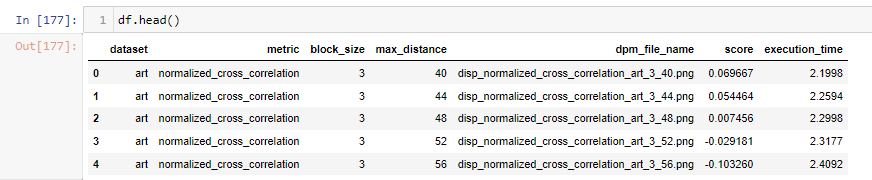

In [85]:
path_results = os.path.join(os.getcwd(), 'results')

if not os.path.isdir(path_results):
    os.mkdir(path_results)

df.to_csv(os.path.join(path_results, 'sm_dp_results.csv'), index=False)

## NSSD took the most time to compute, while SSD the least

Text(0, 0.5, 'Execution time (seconds)')

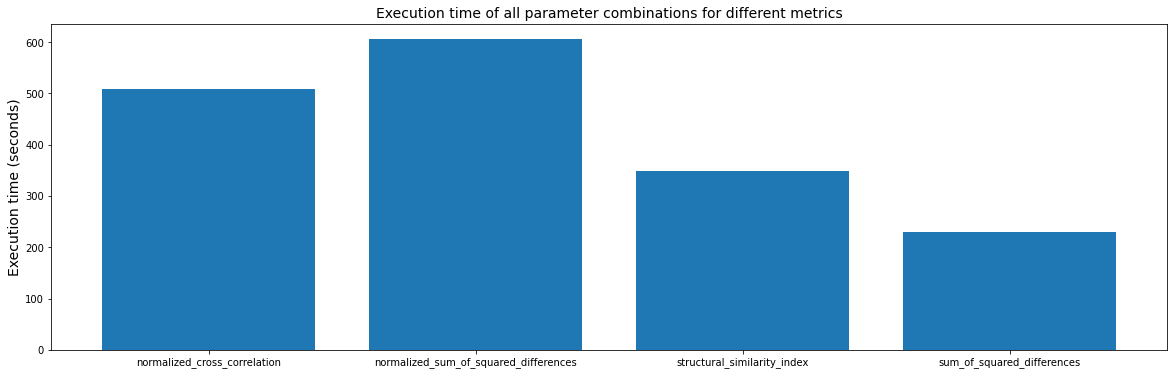

In [86]:
d_metrics_exec_time = df.groupby('metric')[['execution_time']].sum().to_dict()

fig = plt.figure(figsize=(20, 6))
plt.bar(
    d_metrics_exec_time['execution_time'].keys(), 
    d_metrics_exec_time['execution_time'].values()

)
plt.title('Execution time of all parameter combinations for different metrics', fontsize=14)
plt.ylabel('Execution time (seconds)', fontsize=14)

## Block size and metric both influence the scores. For NSSD and SSD with block size of 3 obtained the best score, while for NCC the best score was achieved with block size of 9.

In [89]:
df.groupby(['metric', 'block_size'])[['score']].mean().sort_values('score')

score
metric                                block_size              
structural_similarity_index           5          -5.980085e-01
                                      7          -5.973941e-01
                                      9          -5.790629e-01
                                      3          -4.842990e-01
normalized_cross_correlation          9          -2.105813e-01
                                      7          -1.997509e-01
                                      5          -1.862664e-01
                                      3          -1.470327e-01
normalized_sum_of_squared_differences 3           9.105673e-01
                                      5           1.589220e+00
                                      7           1.616560e+00
                                      9           1.638378e+00
sum_of_squared_differences            3           1.325649e+07
                                      5           7.743846e+08
                                      7           1.803796e+09
                                      9           2.424836e+09

## For NNC and for SSIM, the lower occlusion costs (weights)
## produced better scores, while for NSSD and for SSD, to a certain extent the higher
## occlusion costs produced better results.

In [91]:
df.groupby(['metric', 'occluson_cost'])[['score']].mean().sort_values('score')

score
metric                                occluson_cost              
structural_similarity_index           0.05          -8.183404e-01
                                      0.10          -8.133319e-01
                                      0.15          -8.010378e-01
                                      0.20          -7.733750e-01
                                      0.25          -7.033887e-01
                                      0.30          -6.078533e-01
normalized_cross_correlation          0.10          -4.576209e-01
structural_similarity_index           0.35          -4.333234e-01
                                      0.40          -2.774613e-01
normalized_cross_correlation          0.20          -2.753504e-01
structural_similarity_index           0.45          -2.236889e-01
                                      0.50          -1.951106e-01
normalized_cross_correlation          0.30          -1.888552e-01
                                      0.40          -1.510685e-01
                                      0.50          -1.393941e-01
                                      0.60          -1.338092e-01
                                      0.70          -1.304824e-01
                                      0.80          -1.286139e-01
                                      0.90          -1.275173e-01
                                      1.00          -1.263663e-01
normalized_sum_of_squared_differences 0.70           1.007683e+00
                                      0.80           1.016231e+00
                                      0.90           1.044394e+00
                                      0.60           1.064824e+00
                                      1.00           1.083658e+00
                                      0.50           1.222052e+00
                                      0.40           1.545309e+00
                                      0.30           1.971871e+00
                                      0.20           2.200547e+00
                                      0.10           2.230246e+00
sum_of_squared_differences            1000.00        6.932476e+08
                                      900.00         7.493418e+08
                                      800.00         8.346748e+08
                                      700.00         9.409883e+08
                                      600.00         1.077375e+09
                                      500.00         1.175833e+09
                                      400.00         1.320806e+09
                                      300.00         1.592387e+09
                                      200.00         1.918141e+09
                                      100.00         2.237887e+09

In [97]:
def show_random_disparity_maps(
    df: pd.DataFrame, 
    image_set: str,
    path_data: str, 
    n: int = 20
) -> None:
    """
    """
    indices = random.sample(df.loc[(df['dataset'] == image_set)].index.tolist(), k=n)
    file_names = df.loc[indices, 'dpm_file_name'].tolist()
    
    n_cols = n // 5
    n_rows = n // n_cols
    
    plt.figure(figsize=(16, 16))
    gs = gridspec.GridSpec(n_rows, n_cols)
    gs.update(wspace=0.15, hspace=0.1)
    
    for i, fn in enumerate(file_names):
        img = cv2.imread(os.path.join(path_data, fn), cv2.IMREAD_GRAYSCALE)
        ax = plt.subplot(gs[i])
        ax.imshow(img, cmap='gray')
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        
    plt.subplots_adjust(top=0.94)
    plt.show()

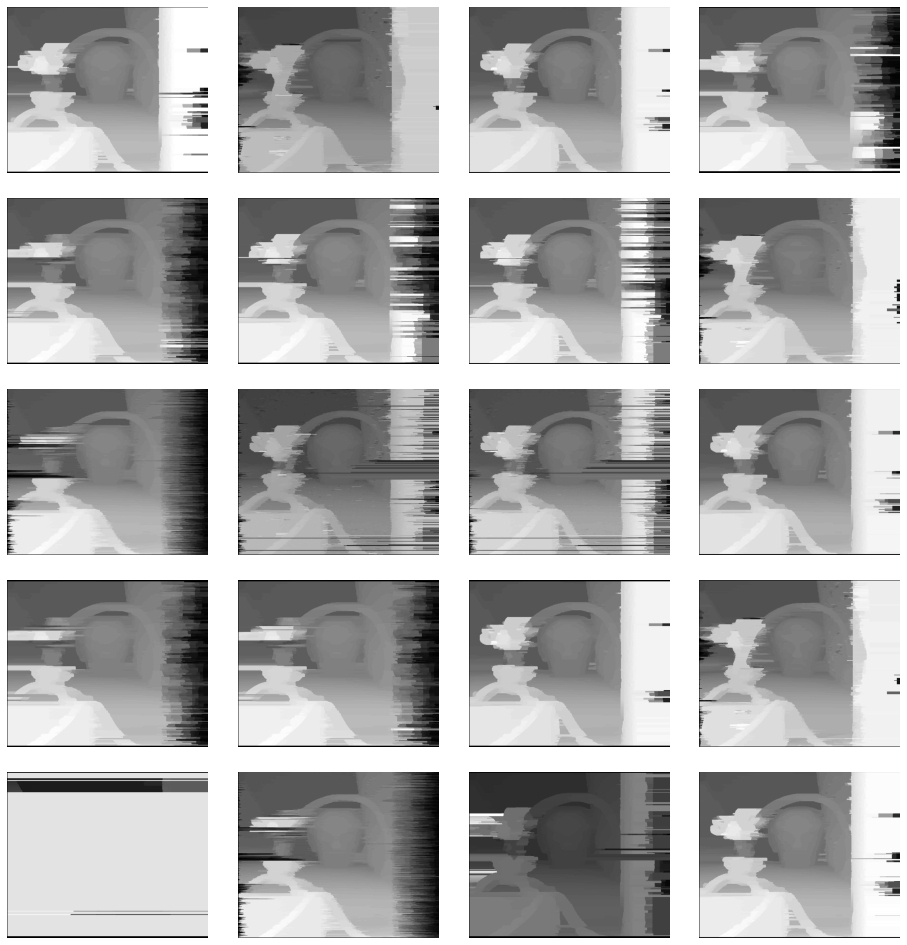

In [99]:
show_random_disparity_maps(df, 'reindeer', path_dpms)

In [113]:
img_set = 'reindeer'
metric = 'structural_similarity_index'
oc = 0.05

df_bss = df.loc[
    (
        (df['dataset'] == img_set)
        & (df['metric'] == metric)
        & (df['occluson_cost'] == oc)
    )
].reset_index(drop=True).copy()

file_names_bss = list(df_bss.loc[:, ['dpm_file_name', 'block_size']].itertuples(name=None, index=False))

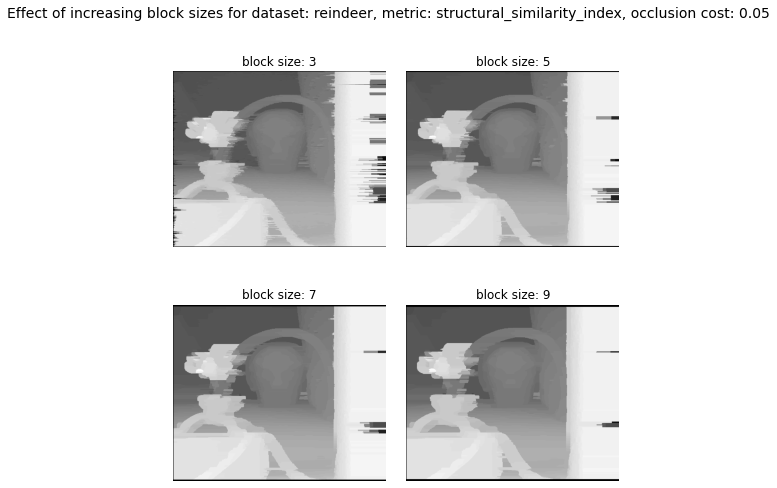

In [115]:
plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 2)
gs.update(wspace=0.1, hspace=0.1)

for i, el in enumerate(file_names_bss):
    fn, bs = el
    img = cv2.imread(os.path.join(path_dpms, fn), cv2.IMREAD_GRAYSCALE)
    ax = plt.subplot(gs[i])
    ax.imshow(img, cmap='gray')
    ax.set_title(f'block size: {bs}')
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')

plt.subplots_adjust(top=0.9)
plt.suptitle(
    f'Effect of increasing block sizes for dataset: '
    f'{img_set}, metric: {metric}, occlusion cost: {oc}',
    fontsize=14
)
plt.show()

In [111]:
img_set = 'reindeer'
metric = 'structural_similarity_index'
bs = 5

df_ocs = df.loc[
    (
        (df['dataset'] == img_set)
        & (df['metric'] == metric)
        & (df['block_size'] == bs)
    )
].reset_index(drop=True).copy()

file_names_ocs = list(df_ocs.loc[:, ['dpm_file_name', 'occluson_cost']].itertuples(name=None, index=False))

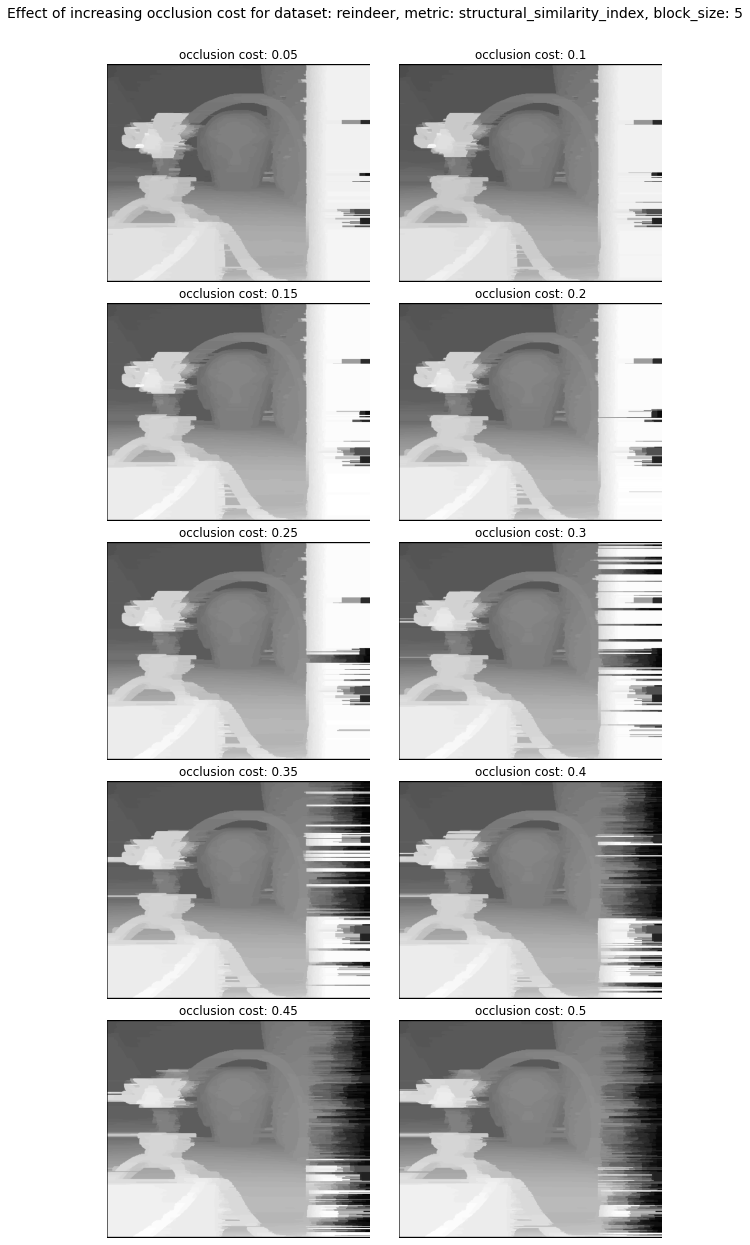

In [112]:
plt.figure(figsize=(10, 20))
gs = gridspec.GridSpec(5, 2)
gs.update(wspace=0.1, hspace=0.1)

for i, el in enumerate(file_names_ocs):
    fn, oc = el
    img = cv2.imread(os.path.join(path_dpms, fn), cv2.IMREAD_GRAYSCALE)
    ax = plt.subplot(gs[i])
    ax.imshow(img, cmap='gray')
    ax.set_title(f'occlusion cost: {oc}')
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')

plt.subplots_adjust(top=0.94)
plt.suptitle(
    f'Effect of increasing occlusion cost for dataset: '
    f'{img_set}, metric: {metric}, block_size: {bs}',
    fontsize=14
)
plt.show()

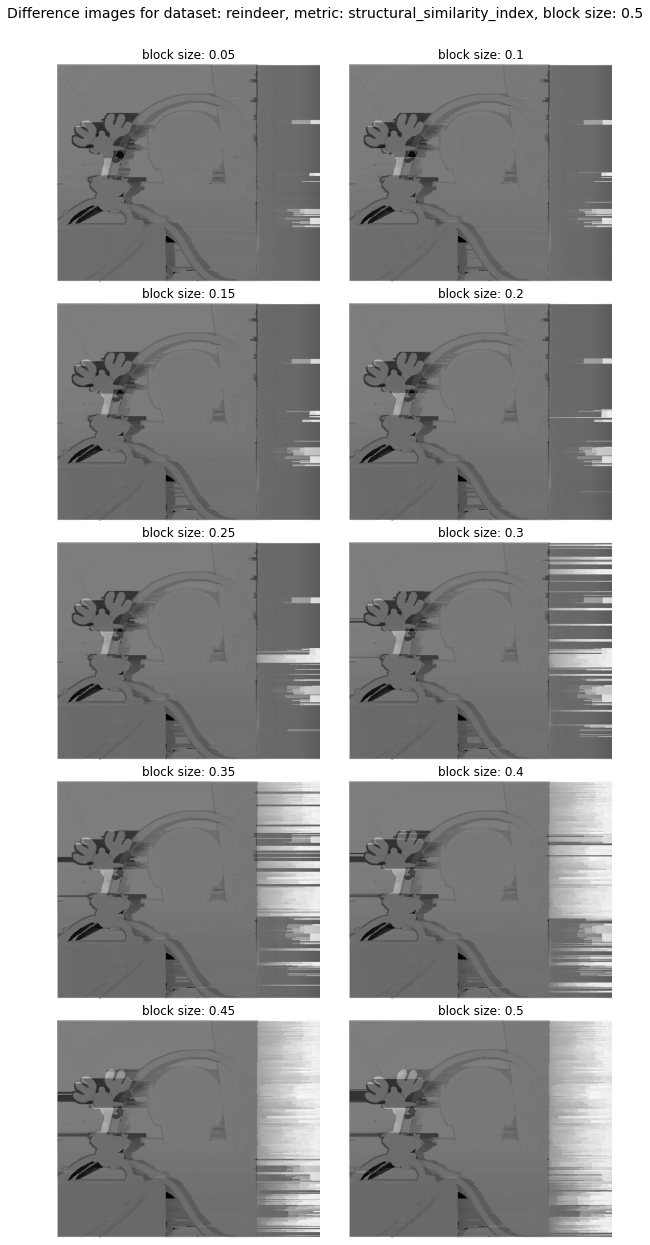

In [119]:
img_disp = cv2.imread(os.path.join(path_data, f'{img_set}_disp.png'), cv2.IMREAD_GRAYSCALE)

# described at https://vision.middlebury.edu/stereo/data/scenes2005/
img_disp = img_disp / 3

plt.figure(figsize=(10, 20))
gs = gridspec.GridSpec(5, 2)
gs.update(wspace=0.1, hspace=0.1)

for i, el in enumerate(file_names_ocs):
    fn, bs = el
    img = cv2.imread(os.path.join(path_dpms, fn), cv2.IMREAD_GRAYSCALE)
    img = img / 3
    img_diff = img_disp - img
    ax = plt.subplot(gs[i])
    ax.imshow(img_diff, cmap='gray')
    ax.set_title(f'block size: {bs}')
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')

plt.subplots_adjust(top=0.94)
plt.suptitle(
    f'Difference images for dataset: '
    f'{img_set}, metric: {metric}, block size: {bs}',
    fontsize=14
)
plt.show()

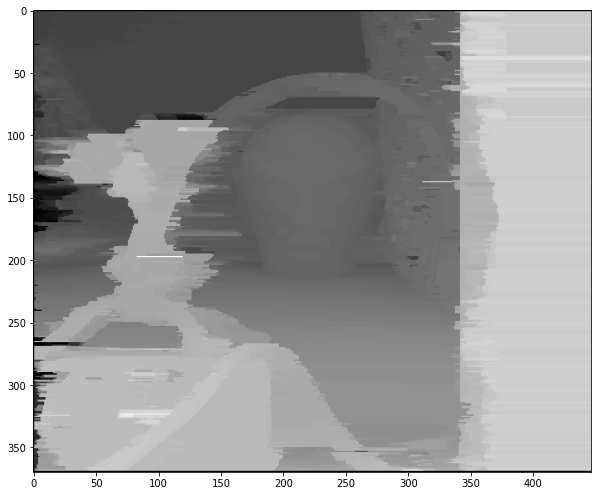

In [120]:
file_dp = 'dp_disp_sum_of_squared_differences_reindeer_3_200.0.png'

dpm = cv2.imread(os.path.join(path_dpms, file_dp), cv2.IMREAD_GRAYSCALE)
dpm = dpm / 3

fig = plt.figure(figsize=(10, 10))
plt.imshow(dpm, cmap='gray')

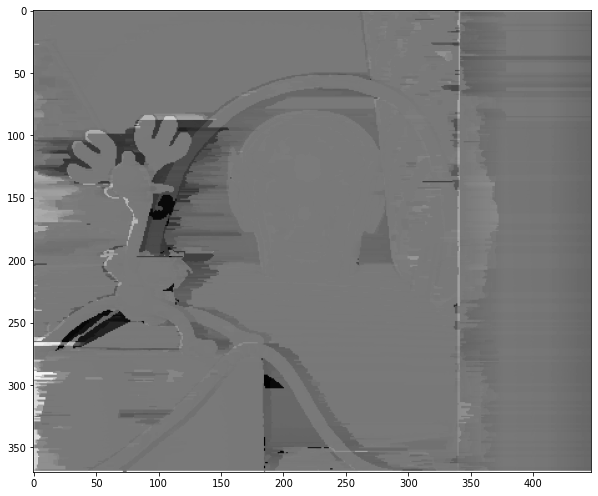

In [121]:
dpm_diff = img_disp - dpm

fig = plt.figure(figsize=(10, 10))
plt.imshow(dpm_diff, cmap='gray')

## Stereo reconstruction of the 3D scene from the calculated disparity map

In [124]:
img_left = cv2.imread(os.path.join(path_data, f'{img_set}_left.png'))
img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
img_left_gr = cv2.cvtColor(img_left, cv2.COLOR_RGB2GRAY)
img_right_gr = cv2.imread(os.path.join(path_data, f'{img_set}_right.png'), cv2.IMREAD_GRAYSCALE)


param_baseline = 160 # mm
param_focal_length = 3740 # pixels
dmin = 230

points_dpm = reconstruct_3d_scene(
    img_left,
    dpm / 3, 
    param_baseline / 1000, 
    param_focal_length, 
    dmin
)

path_points = os.path.join(os.getcwd(), 'points_3d')
fn_points = f'{img_set}_3d_scene_dp.txt'

with open(os.path.join(path_points, fn_points), 'w') as file:
    for point in points_dpm:
        file.write(' '.join(str(p) for p in point))
        file.write('\n')

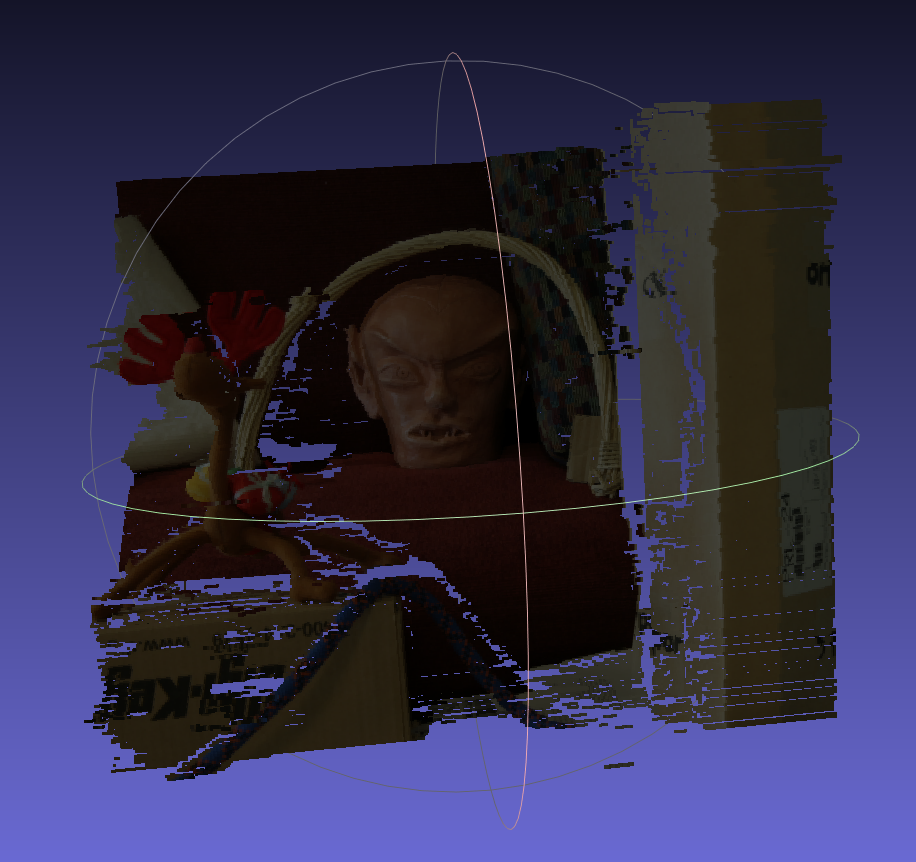

## Compare to OpenCV algorithm for disparities until 80 pixels and for block sizes from 3 to 13

Average elapsed 0.005966666666666666 seconds...


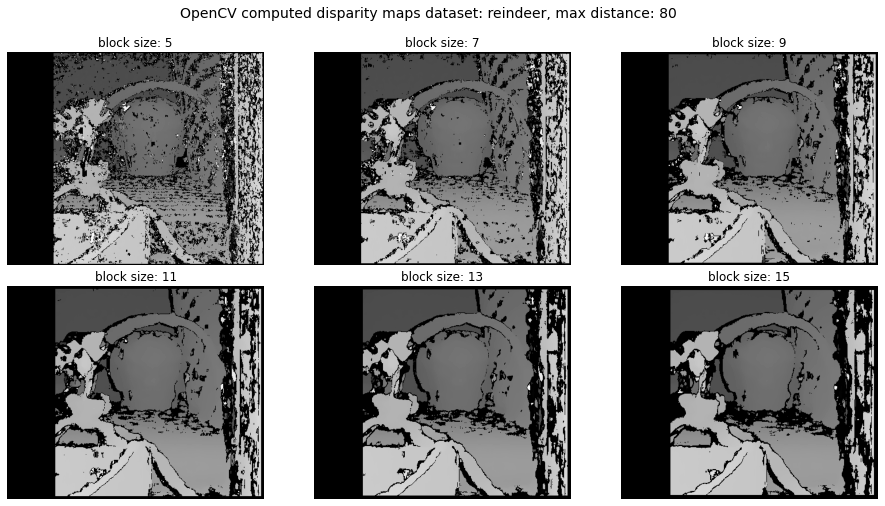

In [148]:
elapsed_times = []
dpms_cv = []
block_sizes = list(range(5, 17, 2))

for bs in block_sizes:
    
    start = time.time()
    stereo = cv2.StereoBM_create(numDisparities=80, blockSize=bs)
    dpm_cv = stereo.compute(img_right_gr ,img_left_gr)
    
    dpms_cv.append(dpm_cv)
    elapsed = round(time.time() - start, 4)
    elapsed_times.append(elapsed)
    
print(f'Average elapsed {np.mean(elapsed_times)} seconds...')

plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(2, 3)
gs.update(wspace=0.1, hspace=0.1)

for i, dpm_cv in enumerate(dpms_cv):
    
    ax = plt.subplot(gs[i])
    ax.imshow(dpm_cv, cmap='gray')
    ax.set_title(f'block size: {block_sizes[i]}')
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')

plt.subplots_adjust(top=0.9)
plt.suptitle(
    f'OpenCV computed disparity maps dataset: '
    f'{img_set}, max distance: {80}',
    fontsize=14
)
plt.show()

## The OpenCV implementation is very fast. The disparity maps get smoother as the block size increases

## Compare OpenCV disparity maps to the ground truth

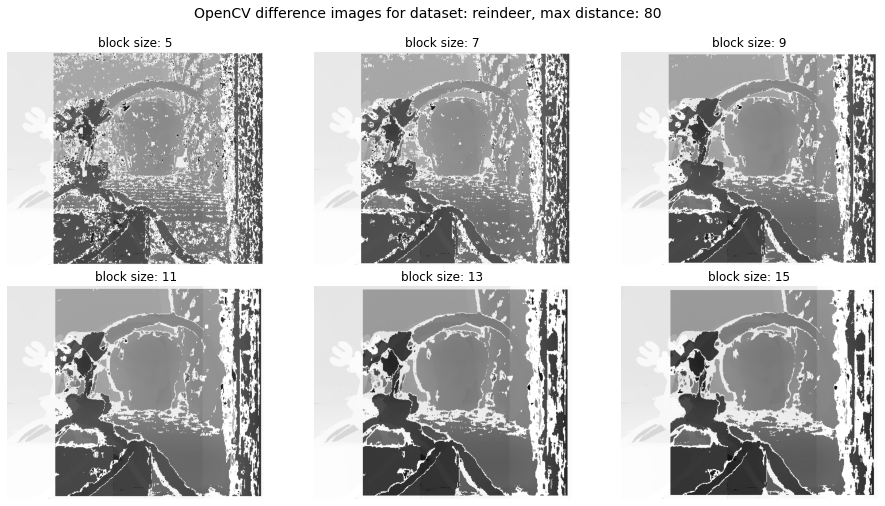

In [153]:
plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(2, 3)
gs.update(wspace=0.1, hspace=0.1)

for i, dpm_cv in enumerate(dpms_cv):
    
    ax = plt.subplot(gs[i])
    img_diff = img_disp - (dpm_cv / 3)
    ax.imshow(img_diff, cmap='gray')
    ax.set_title(f'block size: {block_sizes[i]}')
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')

plt.subplots_adjust(top=0.9)
plt.suptitle(
    f'OpenCV difference images for dataset: '
    f'{img_set}, max distance: 80',
    fontsize=14
)
plt.show()